# Import Libraries

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
from google.cloud import bigquery

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Connect to BigQuery

In [14]:
# Connect to BQ
client = bigquery.Client()
reference_dataset = client.dataset('google_analytics_sample', project='bigquery-public-data')

Using Kaggle's public dataset BigQuery integration.


In [25]:
#tables are of format ga_sessions_20YYMMDD
#fetch tables and convert them to dataframe

test_table = client.get_table(reference_dataset.table('ga_sessions_20160801'))

test_df = client.list_rows(test_table, max_results=2).to_dataframe()

test_df

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,channelGrouping,socialEngagementType
0,NaN,1,1470046245,1470046245,20160801,"{'visits': 1, 'hits': 24, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Firefox', 'browserVersion': 'not ...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",895954260133011192,None,Organic Search,Not Socially Engaged
1,NaN,1,1470084717,1470084717,20160801,"{'visits': 1, 'hits': 24, 'pageviews': 18, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Internet Explorer', 'browserVersi...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...",0288478011259077136,None,Direct,Not Socially Engaged


In [34]:
#Check table column schema for the device column. It translates to index = 7
print(test_table.schema[7].to_standard_sql(), end='\n')

Schema Field of totals colum 

name: "device"
type {
  type_kind: STRUCT
  struct_type {
    fields {
      name: "browser"
      type {
        type_kind: STRING
      }
    }
    fields {
      name: "browserVersion"
      type {
        type_kind: STRING
      }
    }
    fields {
      name: "browserSize"
      type {
        type_kind: STRING
      }
    }
    fields {
      name: "operatingSystem"
      type {
        type_kind: STRING
      }
    }
    fields {
      name: "operatingSystemVersion"
      type {
        type_kind: STRING
      }
    }
    fields {
      name: "isMobile"
      type {
        type_kind: BOOL
      }
    }
    fields {
      name: "mobileDeviceBranding"
      type {
        type_kind: STRING
      }
    }
    fields {
      name: "mobileDeviceModel"
      type {
        type_kind: STRING
      }
    }
    fields {
      name: "mobileInputSelector"
      type {
        type_kind: STRING
      }
    }
    fields {
      name: "mobileDeviceInfo"
      t

# Exploratory Data Analysis (EDA)

***Total Pageviews by Time***

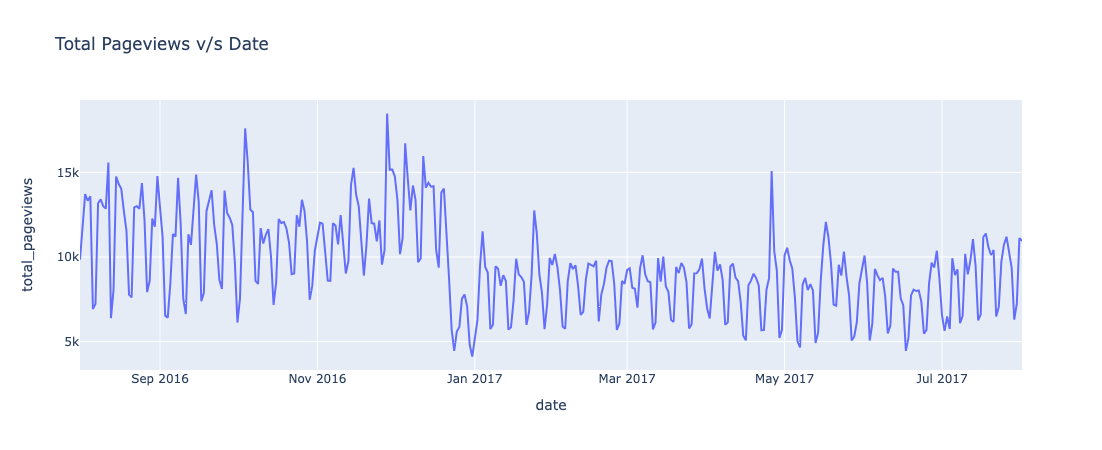

In [51]:
# Pageviews by Time

query = """
            SELECT 
                date, 
                SUM(totals.pageviews) as total_pageviews 
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
            WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            GROUP BY date
            ORDER BY date"""

df = client.query(query).result().to_dataframe()
df['date'] = pd.to_datetime(df['date'])

# Define the plot
fig = px.line(df, x='date', y='total_pageviews', title='Total Pageviews v/s Date')

#add axis labels
fig.update_xaxes(title_text='date')
fig.update_yaxes(title_text='total_pageviews')

# Show the interactive plot
fig.show()

***Pageviews by Channel***

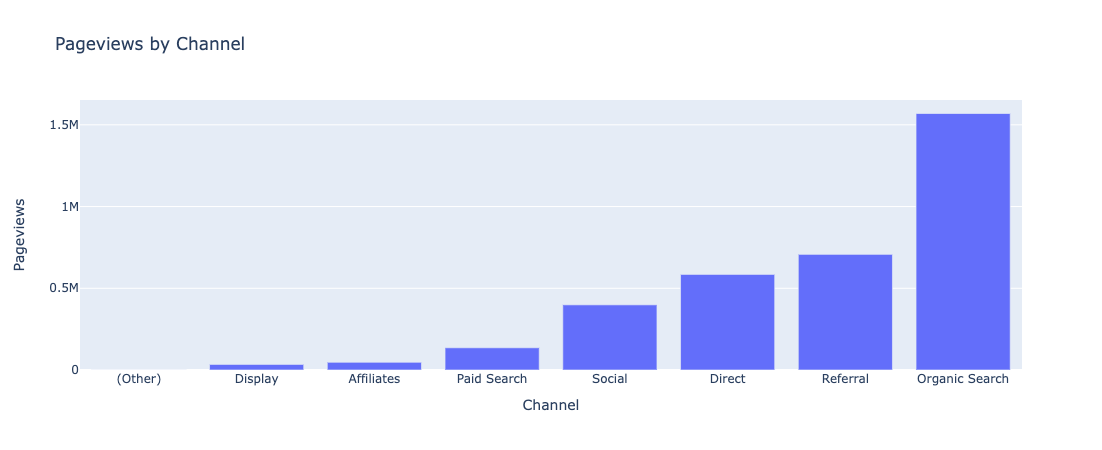

In [57]:
#Calculate total pageviews by channel
query = """
            SELECT 
                channelGrouping as channel_grouping, 
                SUM(totals.pageviews) as total_pageviews 
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
            WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            GROUP BY channelGrouping
            ORDER BY total_pageviews"""

df = client.query(query).result().to_dataframe()

#Define the plot
fig = px.bar(df, x = 'channel_grouping', y = 'total_pageviews', title = "Pageviews by Channel")

#add axis labels
fig.update_xaxes(title_text = 'Channel')
fig.update_yaxes(title_text = 'Pageviews')

fig.show()

# ---------------------

In [2]:
import bq_helper
from bq_helper import BigQueryHelper
google_analytics = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="data:google_analytics_sample")

Using Kaggle's public dataset BigQuery integration.


In [3]:
bq_assistant = BigQueryHelper("bigquery-public-data", "google_analytics_sample")

Using Kaggle's public dataset BigQuery integration.


# **Main Query**

In [6]:
#MAIN QUERY
main_query = """SELECT 
                   session_id,
                   session_bounce_count
                   channel_grouping,
                   page_url,
                   hit_type,
                   event_action,
                   event_value,
                   hit_start_time,
                   interaction_hit_flag,
                   entrance_flag,
                   exit_flag,
                   product_name,
                   transaction_id,
                   transaction_sales_amount,
                   transaction_currency_code,
                   product_array.productSKU as product_sku,
                   product_array.v2ProductName as product_name,
                   product_array.productQuantity as product_quantity,
                   ROUND(product_array.productPrice/1000000,2) as product_price,
                   ROUND(product_array.productRevenue/1000000,2) as product_revenue
            FROM
            (SELECT date, 
                   fullVisitorId as session_id,
                   channelGrouping as channel_grouping,
                   totals.bounces as session_bounce_count,
                   hits.page.pagePath as page_url,
                   hits.type as hit_type,
                   hits.eventInfo.eventAction as event_action,
                   hits.eventInfo.eventValue as event_value,
                   hits.time as hit_start_time,
                   hits.isInteraction as interaction_hit_flag,
                   hits.isEntrance as entrance_flag,
                   hits.isExit as exit_flag,
                   hits.item.productName as product_name,
                   hits.transaction.transactionID as transaction_id,
                   hits.product as product_array,
                   ROUND(hits.transaction.transactionRevenue/1000000,2) as transaction_sales_amount,
                   hits.transaction.currencyCode as transaction_currency_code
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20160801` as GA,
            UNNEST(GA.hits) as hits
            ORDER BY session_id, hit_start_time ASC) as t CROSS JOIN UNNEST(t.product_array) as product_array;"""

main_query = google_analytics.query_to_pandas_safe(main_query)

main_query.head(5)

,session_id,channel_grouping,page_url,hit_type,event_action,event_value,hit_start_time,interaction_hit_flag,entrance_flag,exit_flag,product_name,transaction_id,transaction_sales_amount,transaction_currency_code,product_sku,product_name_1,product_quantity,product_price,product_revenue
0,000722514342430295,NaN,/google+redesign/apparel,PAGE,None,NaN,18101,True,None,None,None,None,NaN,USD,GGOEGHPA002910,Google Trucker Hat,NaN,28.99,NaN
1,000722514342430295,NaN,/google+redesign/apparel,PAGE,None,NaN,18101,True,None,None,None,None,NaN,USD,GGOEYHPA003510,YouTube Trucker Hat,NaN,30.99,NaN
2,000722514342430295,NaN,/google+redesign/apparel,PAGE,None,NaN,18101,True,None,None,None,None,NaN,USD,GGOEGAAX0104,Google Men's 100% Cotton Short Sleeve Hero Tee...,NaN,16.99,NaN
3,000722514342430295,NaN,/google+redesign/apparel,PAGE,None,NaN,18101,True,None,None,None,None,NaN,USD,GGOEGAAX0105,Google Men's 100% Cotton Short Sleeve Hero Tee...,NaN,16.99,NaN
4,000722514342430295,NaN,/google+redesign/apparel,PAGE,None,NaN,18101,True,None,None,None,None,NaN,USD,GGOEGAAX0107,Google Men's 100% Cotton Short Sleeve Hero Tee...,NaN,16.99,NaN


# Metric Calculations

**Datetime Generator**

In [7]:
#Generate the list of dates from 2016-08-01 to 2017-08-01

from datetime import datetime, timedelta

# Start and end dates
start_date_str = "2016-08-01"
end_date_str = "2017-08-01"

# Convert string dates to datetime objects
start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

# Initialize an empty list to store dates
date_list = []

# Populate the list with dates
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date.strftime("%Y%m%d"))
    current_date += timedelta(days=1)
    

**Conversion Rate**

In [8]:
#Conversion Rate
df = main_query.groupby('session_id')['product_revenue'].sum().reset_index().sort_values(by = 'product_revenue', ascending = False)

total_sessions = len(df)
sessions_w_transactions = len(df.query('product_revenue!=0'))
conversion_pct = round((sessions_w_transactions / total_sessions) * 100,2)

print("Comversion Rate: " + str(conversion_pct) + " %")

Comversion Rate: 3.83 %


**Bounce Rate**

In [2]:
#Generate the list of sessions and bounces for the whole 365 days from 08/2016 - 08/2017
full_date_list = []
total_sessions_list = []
sessions_with_bounces_list = []

for i in date_list:  
    table_name = 'bigquery-public-data.google_analytics_sample.ga_sessions_' + str(i)
    query = f""" SELECT
                    CONCAT(fullVisitorId,visitId) as session_id,
                    sum(totals.bounces) as total_bounces_this_session
                FROM
                    `{table_name}` AS GA
                GROUP BY session_id
                ORDER BY total_bounces_this_session DESC"""

    total_sessions = google_analytics.query_to_pandas_safe(query)


    sessions_with_bounces = total_sessions[total_sessions['total_bounces_this_session']>0]
    bounce_rate = round((len(sessions_with_bounces) / len(total_sessions))*100,2)
    
    #add values to the list
    full_date_list.append(datetime.strptime(i, "%Y%m%d"))
    total_sessions_list.append(len(total_sessions))
    sessions_with_bounces_list.append(len(sessions_with_bounces))

df = pd.DataFrame()
df['full_date'] = full_date_list
df['total_sessions'] = total_sessions_list
df['sessions_with_bounces'] = sessions_with_bounces_list

#Extract month and year from the date field
df['month'] = df['full_date'].dt.month
df['year'] = df['full_date'].dt.year

#group bounces and sessions by MM-YY
df1 = df.groupby(['month', 'year'])[['total_sessions', 'sessions_with_bounces']].sum().reset_index()
df1 = df1.sort_values(by = ['year','month'], ascending = True)
df1['bounce_rate_pct'] = round((df1['sessions_with_bounces'] / df1 ['total_sessions']) * 100,2)

NameError: name 'date_list' is not defined

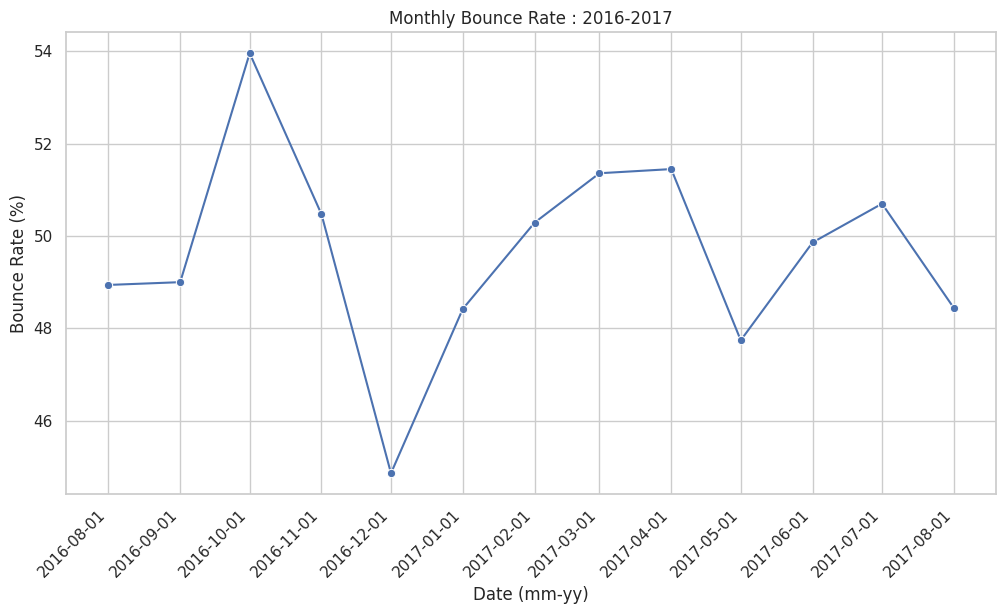

In [142]:
#Visualize the Bounce Rate on a time-series plot

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df1['date'] = pd.to_datetime(df1[['year', 'month']].assign(day=1))

# Sort the DataFrame by the datetime column
df1 = df1.sort_values('date')

# Create a time series plot using Seaborn
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 6))  

# Plot the time series
sns.lineplot(x='date', y='bounce_rate_pct', data=df1, marker='o')

# Format the x-axis labels as 'mm-yy'
plt.xticks(rotation=45, ha='right', ticks=df1['date'])
plt.xlabel('Date (mm-yy)')
plt.ylabel('Bounce Rate (%)')
plt.title('Monthly Bounce Rate : 2016-2017')

plt.show()

# Testing

In [1]:
df

NameError: name 'df' is not defined